<a href="https://colab.research.google.com/github/Yago-Data/Store-Sales-Forecasting---Time-Series/blob/main/STORE_SALES_FORECASTING_FINAL_NOTEBOOK_p_GITHUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# IMPORTAMOS LIBRERÍAS PARA BASES DE DATOS
# ------------------------------------------------------
import numpy as np
import pandas as pd

# IMPORTAMOS LIBRERÍAS PARA MODELOS ESTADÍSTICOS
# ------------------------------------------------------
import statsmodels.api as sm
from prophet import Prophet
import scipy.stats as st
# IMPORTAMOS LIBRERIAS PARA DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

 **DATASET:**

 DOWNLOAD FROM: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook

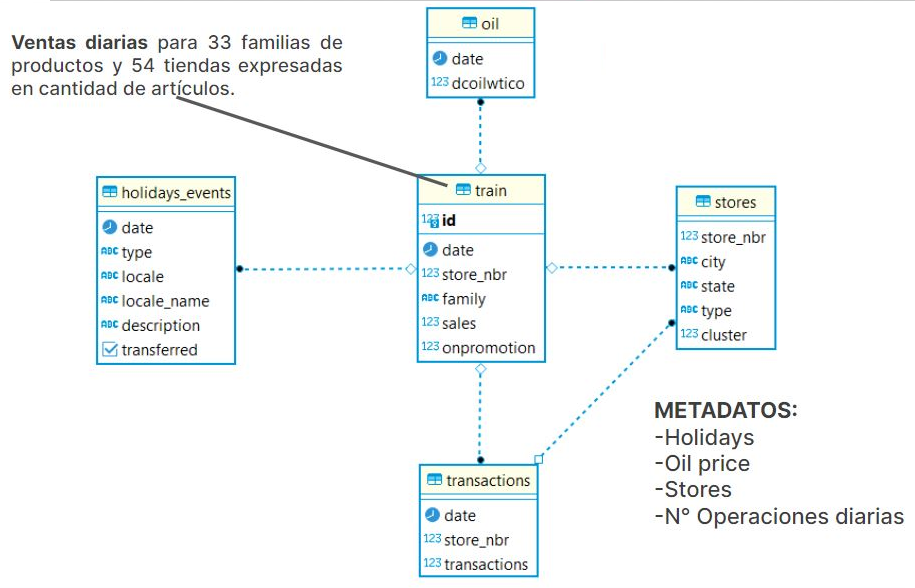

In [100]:
#IMPORT DATABASE

holidays_events = pd.read_csv('/content/drive/MyDrive/STORE SALES DB/holidays_events.csv' , parse_dates=['date'], infer_datetime_format=True)
#oil = pd.read_csv('/content/drive/MyDrive/STORE SALES DB/oil.csv' , parse_dates=['date'], infer_datetime_format=True)
#stores = pd.read_csv('/content/drive/MyDrive/STORE SALES DB/stores.csv' , encoding='utf-8')
#train = pd.read_csv('/content/drive/MyDrive/STORE SALES DB/train.csv' ,parse_dates=['date'], infer_datetime_format=True)
#transactions = pd.read_csv('/content/drive/MyDrive/STORE SALES DB/transactions.csv',parse_dates=['date'], infer_datetime_format=True)

**EXPLORATORY DATA ANALISIS**

In [26]:
# DAMOS UN VISTAZO GENERAL A LAS TABLAS TRAIN, TRANSACTIONS, STORES, OIL, HOLIDAYS
train.info()
transactions.info()
stores.info()
oil.info()
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null

In [27]:
#Ahora ejecutamos comando para ordenar por fecha todas las tablas con columna 'date', por si estas llegasen a estar desordenadas.

train.sort_values(by=['date'], inplace=True, ascending=True)
transactions.sort_values(by=['date'], inplace=True, ascending=True)
oil.sort_values(by=['date'], inplace=True, ascending=True)
holidays.sort_values(by=['date'], inplace=True, ascending=True)

In [28]:
#DAILY TRANSACTION 
train_bydate = train.groupby(by=['date']).agg({'sales':'sum'}).reset_index()

fig = px.scatter(train_bydate, x='date', y='sales', title='Ventas diarias', labels={'date': 'Fecha', 'sales': 'Unidades Vendidas'}, width=1000, height=600)

# Set to continuos line
fig.update_traces(mode='lines')

# Add trendline
trendline=px.scatter(train_bydate, x='date', y='sales', trendline='ols',trendline_color_override="red").data[1]
fig.add_trace(trendline)

fig.show()

In [29]:
#ESTUDIAREMOS QUE DÍA DE LA SEMANA HAY MÁS UNIDADE VENDIDAS

a = train.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).sales.mean().reset_index()
px.line(a, x="dayofweek", y="sales" , color = "year", title = "Ventas promedio por día de semana", width=1000, height=600)

In [30]:
#ESTUDIAREMOS QUE DÍA DE LA SEMANA HAY MÁS OPERACIONES

a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transacciones promedio por día de semana", width=1000, height=600)

In [31]:
train.family.unique()

array(['AUTOMOTIVE', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'SEAFOOD', 'SCHOOL AND OFFICE SUPPLIES',
       'PRODUCE', 'PREPARED FOODS', 'POULTRY', 'PLAYERS AND ELECTRONICS',
       'PET SUPPLIES', 'PERSONAL CARE', 'MEATS', 'MAGAZINES',
       'LIQUOR,WINE,BEER', 'LINGERIE', 'LAWN AND GARDEN', 'LADIESWEAR',
       'HOME CARE', 'HOME APPLIANCES', 'CLEANING', 'DAIRY', 'DELI',
       'EGGS', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'GROCERY I', 'FROZEN FOODS'], dtype=object)

In [32]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
fig=px.bar(a, y = "family", x="sales", color = "family", title = "Ventas promedio por familia", width=1000, height=700)
fig.update_traces(showlegend=False)
fig.update_layout(yaxis={'tickfont':{'size':11}})
fig.show()

The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

In [33]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
    
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12,8))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [34]:
str44_periodogram=train_bydate['sales']

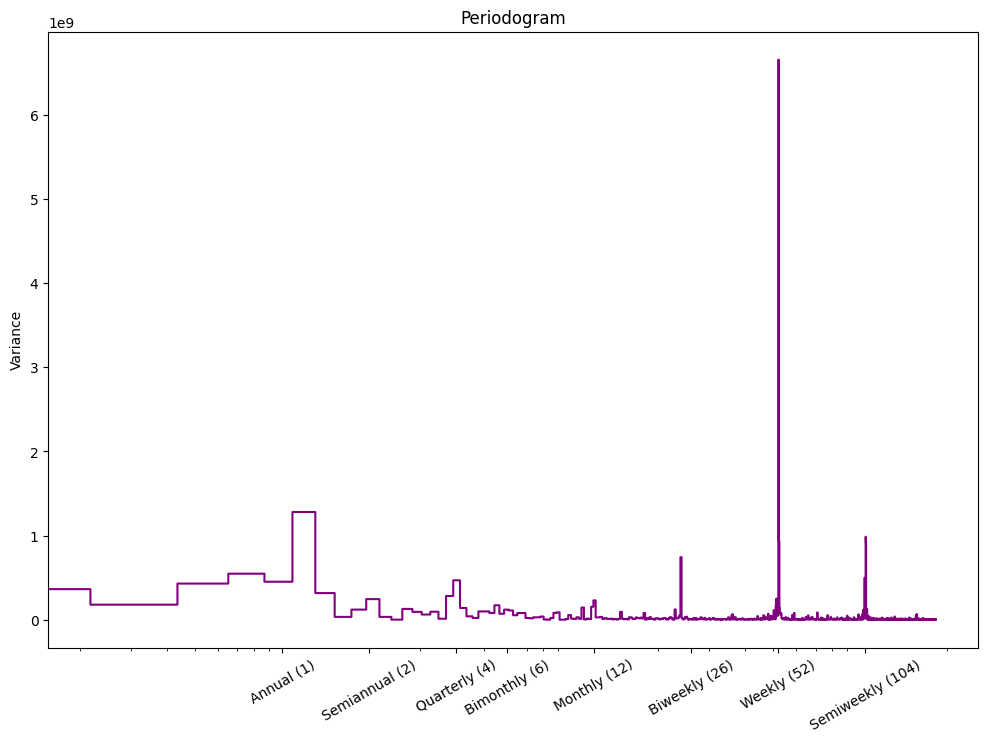

In [35]:
plot_periodogram(str44_periodogram);

ACÁ HAY QUE DECIR PARA QUE HICIMOS EL PERIODOGRAM 

VAMOS A VER CUÁL FUE LA TIENDA CON MÁS VENTAS Y VER SI ES REPRESENTATIVA DE LAS VENTAS ACUMULADAS


In [36]:
#Creating store level metrics
sales_bystr=train.groupby(['store_nbr'],as_index=False)['sales'].agg(['sum']).reset_index()
sales_bystr = sales_bystr.sort_values(by='sum', ascending=False)

sales_bystr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 43 to 51
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   store_nbr  54 non-null     int64  
 1   sum        54 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.3 KB


In [37]:
fig = px.bar(sales_bystr, x='store_nbr', y='sum')
fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

PARA MAYOR SIMPLICIDAD VAMOS A TRABAJAR SOLAMENTE CON LA TIENDA 44

In [38]:
#AHORA VEMOS LA TIENDA CON MÁS VENTAS EN EL ÚLTIMO AÑO DE CADA TIPO DE TIENDA

In [41]:
diccionario_type = stores.set_index('store_nbr')['type'].to_dict()

In [42]:
train['store_type'] = train['store_nbr'].map(diccionario_type)

In [43]:
train.head().set_index('date')

,id,store_nbr,family,sales,onpromotion,store_type
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,D
2013-01-01,1194,42,CELEBRATION,0.0,0,D
2013-01-01,1193,42,BREAD/BAKERY,0.0,0,D
2013-01-01,1192,42,BOOKS,0.0,0,D
2013-01-01,1191,42,BEVERAGES,0.0,0,D


In [44]:
sales_store_type = train.groupby(['store_type', 'store_nbr'])['sales'].sum().reset_index()
#sales_store_type = ventas_por_cluster_y_tienda.sort_values(['cluster', 'venta_total'], ascending=[True, False])
sales_store_type

,store_type,store_nbr,sales
0,A,44,6.208755e+07
1,A,45,5.449801e+07
2,A,46,4.189606e+07
3,A,47,5.094831e+07
4,A,48,3.593313e+07
5,A,49,4.342010e+07
6,A,50,2.865302e+07
7,A,51,3.291149e+07
8,A,52,2.696170e+06
9,B,9,2.640944e+07


In [47]:
# Crear DataFrame de pandas
df = sales_store_type

# Seleccionar un tipo de tienda específico
tipo_tienda = 'A'
df_filtrado = df[df['store_type'] == tipo_tienda]

# Ordenar DataFrame filtrado por ventas en forma descendente
df_ordenado = df_filtrado.sort_values(['sales'], ascending=True)
df_ordenado

,store_type,store_nbr,sales
8,A,52,2.696170e+06
6,A,50,2.865302e+07
7,A,51,3.291149e+07
4,A,48,3.593313e+07
2,A,46,4.189606e+07
5,A,49,4.342010e+07
3,A,47,5.094831e+07
1,A,45,5.449801e+07
0,A,44,6.208755e+07


In [45]:
from plotly.subplots import make_subplots
# Crear subplots
fig = make_subplots(rows=2, cols=3, subplot_titles=('Tiendas tipo A', 'Tiendas tipo B', 'Tiendas tipo C', 'Tiendas tipo D', 'Tiendas tipo E'))

In [48]:
# Crear los objetos de barras y agregarlos a los subplots correspondientes
for i, tipo_tienda in enumerate(sales_store_type['store_type'].unique()):
    row = (i // 3) + 1
    col = (i % 3) + 1
    df_filtrado = df[df['store_type'] == tipo_tienda].sort_values('sales', ascending=False)
    fig.add_trace(go.Bar(x=df_filtrado['store_nbr'], y=df_filtrado['sales'], name=tipo_tienda), row=row, col=col)

In [49]:
# Actualizar el diseño de los subplots
fig.update_layout(height=800, width=1200, title_text='Ventas por tienda y tipo de tienda', showlegend=False)
fig.update_xaxes(type='category')

# Mostrar los subplots
fig.show()

DEMOSTRAR POR QUE ES BUENO USAR LAS TRANSACCIONES MENSUALES PARA HACER ELEGIR EL MODELO

In [50]:
transactions["date"] = pd.to_datetime(transactions.date)
transbydate = transactions.groupby('date')['transactions'].sum().reset_index()
transbydate = transbydate.set_index('date')
y = transbydate['transactions'].resample('MS').sum()

In [51]:
#Eliminamos el mes de agosto porque está incompleto
last_row = y.tail(1).index
y.drop (last_row, inplace=True)

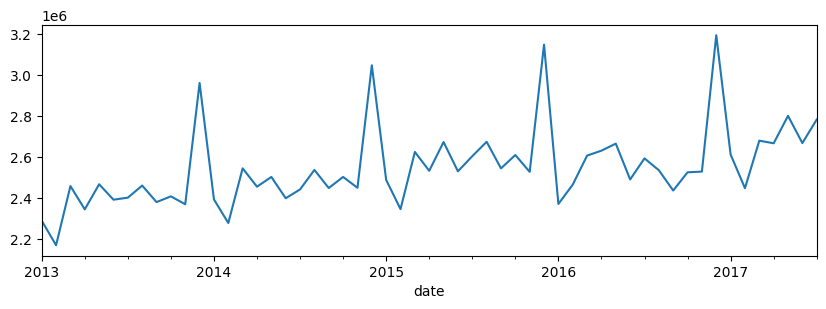

In [53]:
y.plot(figsize=(10, 3))
plt.show()

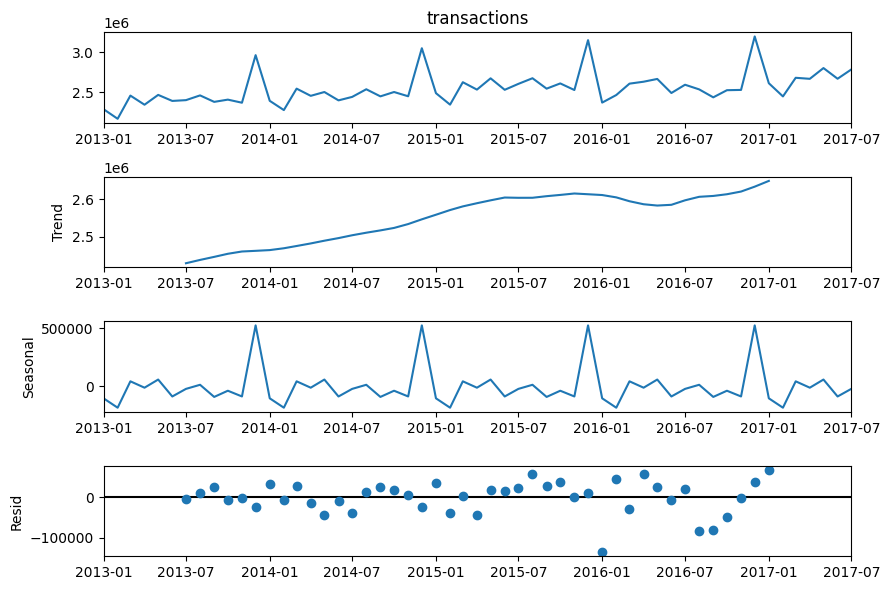

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

EXPLICAR PARA QUE DIABLO SERVIRIA ESTO DE PONER LAS COMPONENTES DEL MODELO ADITIVO

PROBAMOS EL MODELO ARIMA CON LA LIBRERIA DE AUTOARIMA

In [56]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:00


In [57]:
import pmdarima as pm

In [64]:
#slicing train-test 80-20
TEST_SIZE = int(y.size*0.2)
train, test = y.iloc[:-TEST_SIZE], y.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], y.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((44,), (44,), (11,), (11,))

In [94]:
testdef = y.iloc[-TEST_SIZE:]

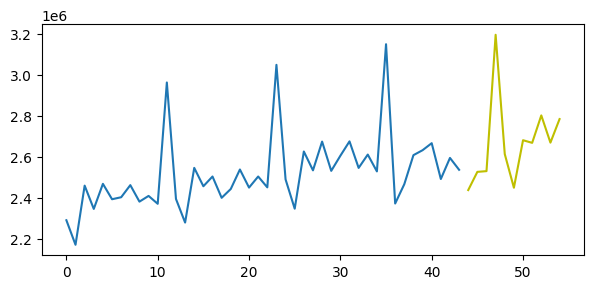

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(x_train, train)
ax.plot(x_test, test, color='y')

Pmdarima es una biblioteca de Python que se utiliza para realizar análisis de series de tiempo y modelos de pronóstico basados en ARIMA (Autoregresivo Integrado de Media Movil) y modelos SARIMA (Seasonal ARIMA) 
Optimización automática de parámetros del ARIMA y parámetros estacionales


In [65]:
#explicar para que diablos usé el modelo de normalidad antes de correr ARIMA
from scipy.stats import normaltest
normaltest(train)[1]

1.181570685448591e-05

In [69]:
from pmdarima.arima import auto_arima

In [71]:
#Escogemos el valor del termino diferencial para eliminar la tendencia
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [72]:
#corremos auto arima
auto = pm.auto_arima(train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=791.269, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=799.417, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=793.185, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=792.621, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=791.101, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=784.659, Time=0.26 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=785.910, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=787.702, Time=1.48 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=787.047, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 7.135 seconds


Text(0, 0.5, 'N° transactions')

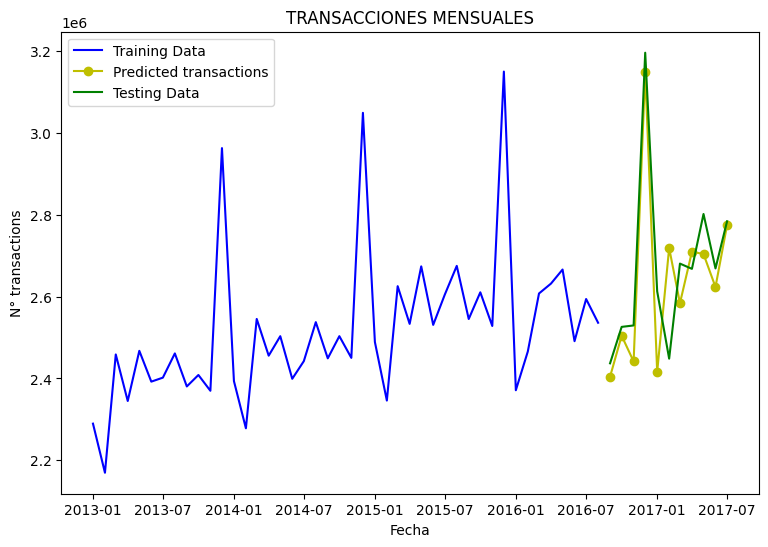

In [74]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

# --------------------- Actual vs. Predicted --------------------------
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='y', marker='o',label='Predicted transactions')
ax.plot(test, color='green', label='Testing Data')
ax.set_title('TRANSACTIONS')
ax.set_xlabel('Dates')
ax.set_ylabel('Transactions')

ax.legend()


# ------------------ GRAPH LABELS ---------------

ax.set_title('TRANSACCIONES MENSUALES')
ax.set_xlabel('Fecha')
ax.set_ylabel('N° transactions')

ver de un tutorial de pmarima de donde sale el forecast graficado en verde clarito

In [75]:
from prophet import Prophet

In [76]:
yprophet=train.to_frame(name='transactions')
yprophet['date'] = yprophet.index
yprophet = yprophet.reindex(columns=['date', 'transactions'])
yprophet.head()

,date,transactions
date,,
2013-01-01,2013-01-01,2289558
2013-02-01,2013-02-01,2169615
2013-03-01,2013-03-01,2458683
2013-04-01,2013-04-01,2344905
2013-05-01,2013-05-01,2467465


In [77]:
#renombramos las columnas del df para poder correr prophet
yprophet.rename(columns={'date': 'ds', 'transactions':'y'}, inplace=True)
yprophet.head()

,ds,y
date,,
2013-01-01,2013-01-01,2289558
2013-02-01,2013-02-01,2169615
2013-03-01,2013-03-01,2458683
2013-04-01,2013-04-01,2344905
2013-05-01,2013-05-01,2467465


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkoolhfe/s2t_go5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkoolhfe/ajg_tx9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46319', 'data', 'file=/tmp/tmpnkoolhfe/s2t_go5_.json', 'init=/tmp/tmpnkoolhfe/ajg_tx9t.json', 'output', 'file=/tmp/tmpnkoolhfe/prophet_modelwwlviqxh/prophet_model-20230419031859.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:18:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 500x200 with 0 Axes>

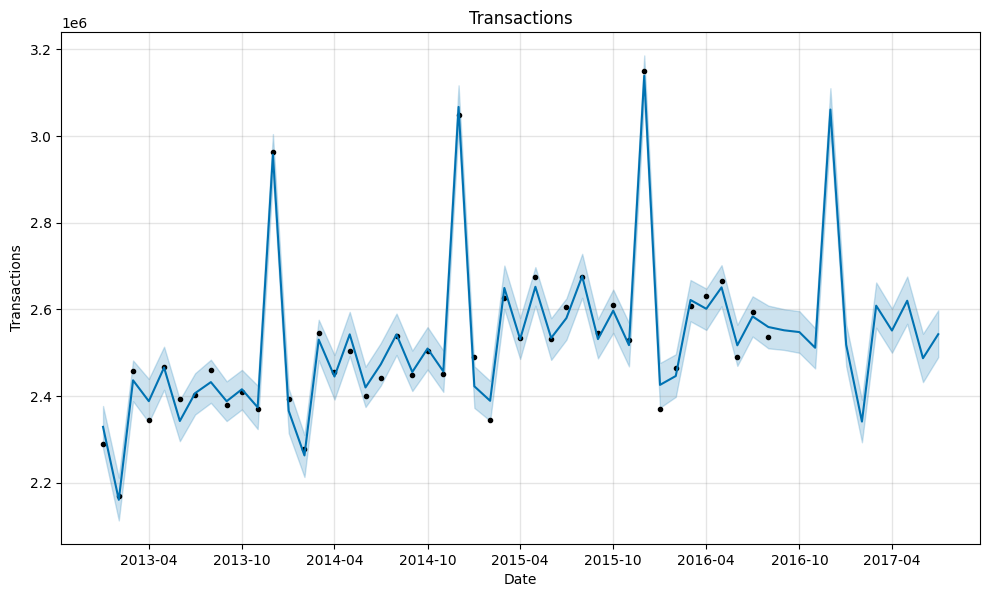

In [80]:
# set the uncertainty interval to 95% (the Prophet default is 80%)


yprophet_model = Prophet(interval_width=0.95)
yprophet_model.fit(yprophet)

#estos son los valores para los 11 períodos posteriores a los datos de train
yprophet_forecast = yprophet_model.make_future_dataframe(periods=11, freq='MS')
yprophet_forecast = yprophet_model.predict(yprophet_forecast)

plt.figure(figsize=(5, 2))
yprophet_model.plot(yprophet_forecast, xlabel = 'Date', ylabel = 'Transactions')
plt.title('Transactions');

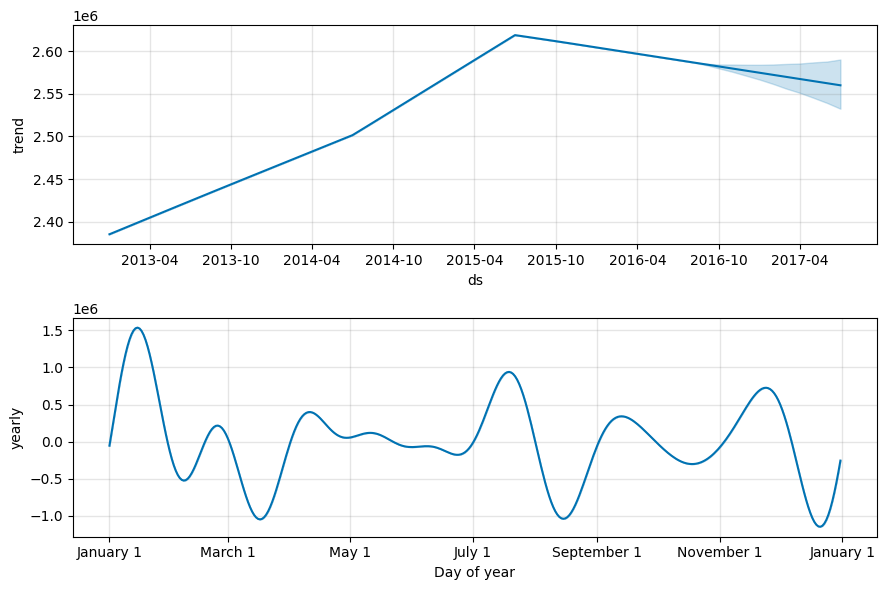

In [81]:
fig2 = yprophet_model.plot_components(yprophet_forecast)

In [82]:
prophet_forecast=yprophet_forecast[['ds','yhat']].tail(11)
prophet_forecast

,ds,yhat
44,2016-09-01,2.551670e+06
45,2016-10-01,2.547559e+06
46,2016-11-01,2.511444e+06
47,2016-12-01,3.060652e+06
48,2017-01-01,2.518578e+06
49,2017-02-01,2.341250e+06
50,2017-03-01,2.608435e+06
51,2017-04-01,2.551120e+06
52,2017-05-01,2.619827e+06
53,2017-06-01,2.487289e+06


Text(0, 0.5, 'N° transactions')

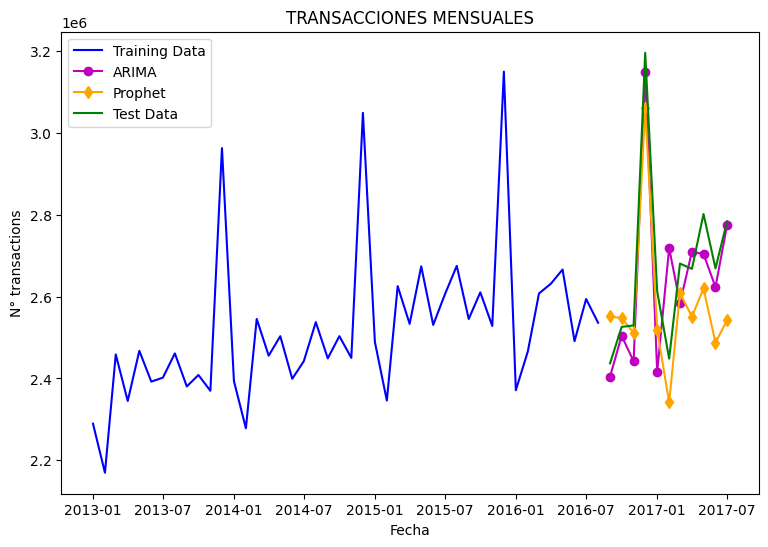

In [83]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

# --------------------- Actual vs. Predicted --------------------------
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='m', marker='o',
             label='ARIMA')
ax.plot(test.index, prophet_forecast['yhat'], color='orange', marker='d',
             label='Prophet')
ax.plot(test, color='green', label='Test Data')
ax.set_title('TRANSACTIONS')
ax.set_xlabel('Dates')
ax.set_ylabel('Transactions')

ax.legend()


# ------------------ GRAPH LABELS ---------------

ax.set_title('TRANSACCIONES MENSUALES')
ax.set_xlabel('Fecha')
ax.set_ylabel('N° transactions')

AJUSTAMOS EL changepoint_prior_scale PARA HACER MENOS SENSIBLES LOS CAMBIO EN LA TENDENCIA



DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkoolhfe/xvu_uzyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkoolhfe/gfwg345m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50362', 'data', 'file=/tmp/tmpnkoolhfe/xvu_uzyw.json', 'init=/tmp/tmpnkoolhfe/gfwg345m.json', 'output', 'file=/tmp/tmpnkoolhfe/prophet_modelauuy5m19/prophet_model-20230419032208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1800x600 with 0 Axes>

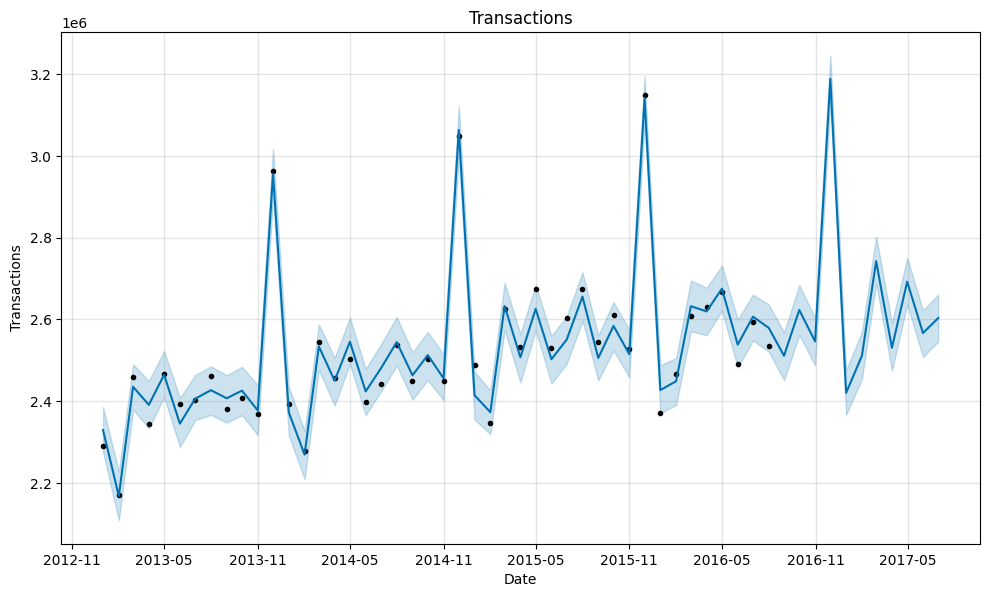

In [88]:
# set the uncertainty interval to(the Prophet default is 80%)


yprophet_model = Prophet(
    interval_width=0.95,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False, 
    changepoint_prior_scale=0.009
    )
yprophet_model.fit(yprophet)

#estos son los valores para los 11 períodos posteriores a los datos de train
yprophet_forecast = yprophet_model.make_future_dataframe(periods=11, freq='M')
yprophet_forecast = yprophet_model.predict(yprophet_forecast)

plt.figure(figsize=(18, 6))
yprophet_model.plot(yprophet_forecast, xlabel = 'Date', ylabel = 'Transactions')
plt.title('Transactions');

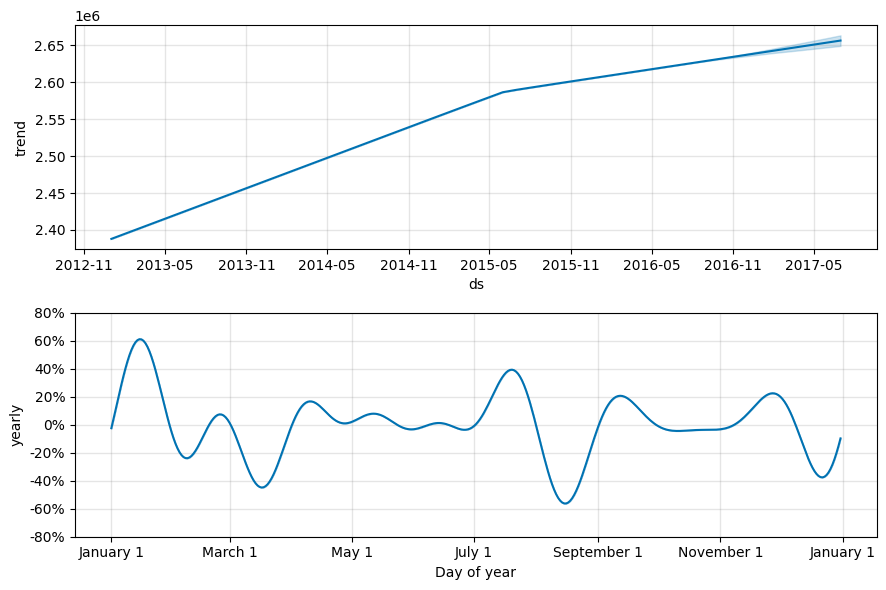

In [89]:
fig2 = yprophet_model.plot_components(yprophet_forecast)

In [90]:
prophet_forecast=yprophet_forecast[['ds','yhat']].tail(11)
prophet_forecast

,ds,yhat
44,2016-08-31,2.511324e+06
45,2016-09-30,2.623336e+06
46,2016-10-31,2.546344e+06
47,2016-11-30,3.188968e+06
48,2016-12-31,2.420363e+06
49,2017-01-31,2.511101e+06
50,2017-02-28,2.742809e+06
51,2017-03-31,2.530701e+06
52,2017-04-30,2.692464e+06
53,2017-05-31,2.566928e+06


Text(0, 0.5, 'N° transactions')

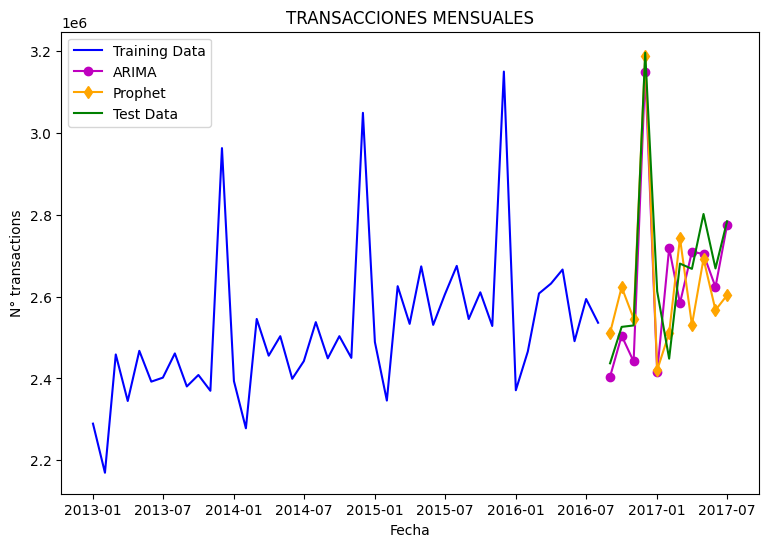

In [91]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

# --------------------- Actual vs. Predicted --------------------------
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='m', marker='o',
             label='ARIMA')
ax.plot(test.index, prophet_forecast['yhat'], color='orange', marker='d',
             label='Prophet')
ax.plot(test, color='green', label='Test Data')
ax.set_title('TRANSACTIONS')
ax.set_xlabel('Dates')
ax.set_ylabel('Transactions')

ax.legend()


# ------------------ GRAPH LABELS ---------------

ax.set_title('TRANSACCIONES MENSUALES')
ax.set_xlabel('Fecha')
ax.set_ylabel('N° transactions')

In [92]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [95]:
#intentaremos crear un dataframe con las predicciones
fechas = pd.date_range(start = '2016-09-01', end = '2017-07-01', freq = 'MS')

comparamodelos = pd.DataFrame()

comparamodelos['fecha'] = fechas
comparamodelos['Test']= testdef.tolist()
comparamodelos['ARIMA'] = forecasts
comparamodelos['Prophet'] = prophet_forecast['yhat'].tolist()

comparamodelos

,fecha,Test,ARIMA,Prophet
0,2016-09-01,2436974,2.404338e+06,2.511324e+06
1,2016-10-01,2526000,2.504372e+06,2.623336e+06
2,2016-11-01,2529516,2.441563e+06,2.546344e+06
3,2016-12-01,3195971,3.148575e+06,3.188968e+06
4,2017-01-01,2612848,2.415951e+06,2.420363e+06
5,2017-02-01,2448370,2.718807e+06,2.511101e+06
6,2017-03-01,2680645,2.583978e+06,2.742809e+06
7,2017-04-01,2667808,2.709712e+06,2.530701e+06
8,2017-05-01,2801884,2.703959e+06,2.692464e+06
9,2017-06-01,2668863,2.623441e+06,2.566928e+06


In [96]:
mean_absolute_percentage_error(comparamodelos['Test'], comparamodelos['ARIMA'])

0.033128390832886996

In [97]:
mean_absolute_percentage_error(comparamodelos['Test'], comparamodelos['Prophet'])

0.03580616870011038

ACÁ TENDRÍA QUE IR MÁS PIOLA LAS MÉTRICAS DEL MODELO Y POR QUÉ ELEGÍ EL PROPHET

VEMOS QUE AÚN SIN LA INFLUENCIA DE LOS HOLIDAY EL MODELO PROPHET SE COMPORTA MUY BIEN


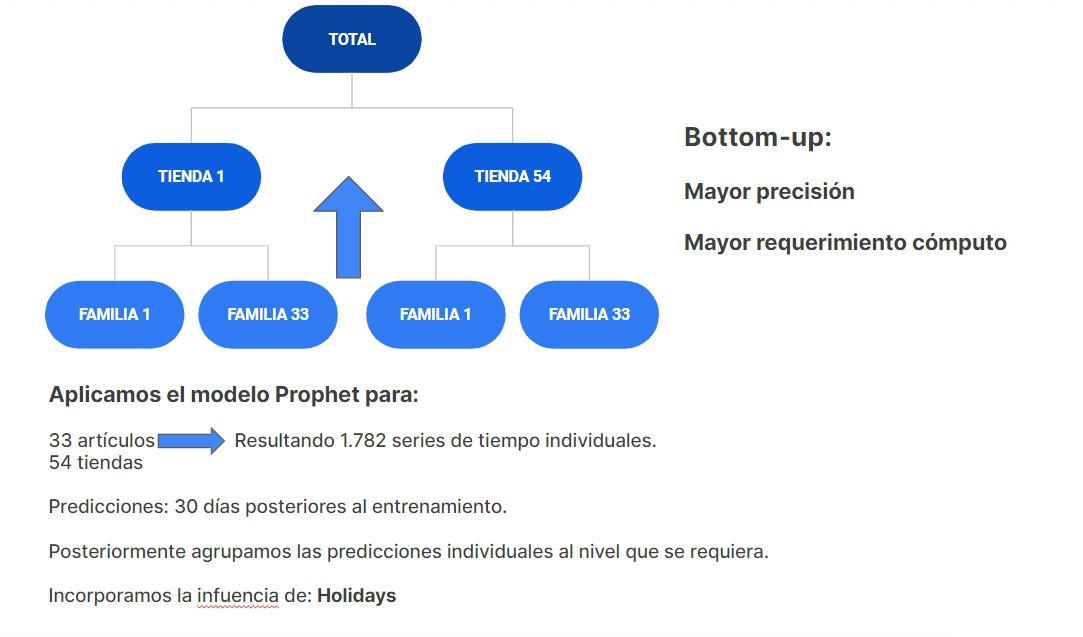

a partir de acá sale de este notebook: https://colab.research.google.com/drive/1hYONUkSdzbPLHrtK6tFretWkbyC2VIkj#scrollTo=eiO2JRPzIuwW

In [98]:
# Import the csv file and explore it
sales_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/store_sales_5-3.csv')
# Convert ds to datetime
sales_pd['ds'] = pd.to_datetime(sales_pd['ds'])
# Display info
sales_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   store   int64         
 2   item    object        
 3   y       float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 91.6+ MB


In [101]:
#AGREGAMOS Y ACOMODAMOS EL DF DE HOLIDAYS PARA INCLUIRLO EN EL MODELO


holidays = holidays_events[['description', 'date']].loc[holidays_events['locale'] == 'National']

 #si lo pongo me saca el año nuevo 2017 pero no importa

holidays.columns = ['holiday', 'ds']
holidays

,holiday,ds
14,Primer Grito de Independencia,2012-08-10
19,Independencia de Guayaquil,2012-10-09
20,Traslado Independencia de Guayaquil,2012-10-12
21,Dia de Difuntos,2012-11-02
22,Independencia de Cuenca,2012-11-03
...,...,...
345,Navidad-3,2017-12-22
346,Navidad-2,2017-12-23
347,Navidad-1,2017-12-24
348,Navidad,2017-12-25


In [ ]:
def apply_model(store_pd):
  # instantiate the model and set parameters
  model = Prophet(
      interval_width=0.95,
      weekly_seasonality=True,
      yearly_seasonality=True,
      holidays=holidays,
      seasonality_mode='multiplicative'
  )
  model.add_seasonality(name='monthly', period=30.5, fourier_order=8)
  # fit the model to historical data
  model.fit(store_pd)
  # Create a data frame that lists 30 dates starting from Ago 15 2017
  future = model.make_future_dataframe(
      periods=30,
      freq='d',
   )
  # Out of sample prediction
  future = model.predict(future)
  # Create a data frame that contains store, item, y, and yhat
  f_pd = future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
  st_pd = store_pd[['ds', 'store', 'item', 'y']]
  result_pd = f_pd.join(st_pd.set_index('ds'), on='ds', how='left')
  # fill store and item
  result_pd['store'] = store_pd['store'].iloc[0]
  result_pd['item'] = store_pd['item'].iloc[0]
  return result_pd[['store', 'item', 'ds', 'y', 'yhat',
                    'yhat_upper', 'yhat_lower']]
# Apply the function to all store-items
results = sales_pd.groupby(['store', 'item']).apply(apply_model)

In [ ]:
results.to_csv('/content/drive/MyDrive/Colab Notebooks/data/prophetdirecto-19-4.csv', index=False)

agregamos esta línea de código para que al correr escriba un cvs por si dejamos funcionando la pc y nos vamos y esta se suspende o cae la sesión del notebook para no perder los resultados del modelo

In [ ]:
# Import the csv file and explore it
prophetdirecto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/prophetdirecto.csv')
# Convert ds to datetime
prophetdirecto['ds'] = pd.to_datetime(prophetdirecto['ds'])

In [ ]:
#vamos a reemplazar las predicciones negativas por cero
prophetdirecto['yhat'] = prophetdirecto['yhat'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
#DEJAMOS SOLAMENTE LAS FILAS HASTA DONDE HAY SALES REALES (es decir para los datos de entrenamiento)

fecha_deseada='2017-08-15'
df_hasta_fecha = prophetdirecto.loc[prophetdirecto['ds'] <= fecha_deseada]
df_hasta_fecha

In [ ]:
#DEJAMOS SOLAMENTE LAS FILAS DE LAS PREDICCIONES PARA LAS QUE NO HAY SALES 
df_predicciones=prophetdirecto.loc[prophetdirecto['ds'] > fecha_deseada]
df_predicciones

In [ ]:
df_hasta_fecha.reset_index(level=0 ,drop=True, inplace=True)

In [ ]:
#AGRUPAMOS PARA LUEGO PASAR DE FORMATO LONG A WIDTH
grouped_final = df_hasta_fecha.groupby(['ds','store', 'item']).sum()
grouped_final

In [ ]:
#PASAMOS A FORMATO WIDTH
unstacked_final = grouped_final.unstack(level=('store', 'item'))
unstacked_final

In [ ]:
#SELECCIONAMOS SOLAMENTE LAS COLUMNAS DE y Y DE yhat
parar2=unstacked_final.loc[:, [('y'), ('yhat')]]
parar2

In [ ]:
#CALCULO AUXILIAR PARA SABER QUÉ INDICE USAR PARA SEPARAR LAS COLUMNAS y DE yhat
columnas = parar2.columns.tolist()
len(columnas)/2

ojo ver si en lugar de R2 me conviene otra métrica

In [ ]:
#IMPORTAMOS LAS MÉTRICAS DE R2 PARA CALCULARLO FACILMENTE

from sklearn.metrics import r2_score

# Columnas de sales (y) y su modelo de prophet (yhat)

columnas_y= columnas[:1782]
columnas_yhat = columnas[1782:]

In [ ]:
# Crear un diccionario para almacenar los resultados del R2
results = {}

# Iterar sobre todas las combinaciones posibles de pares de columnas
for i in range(len(columnas_y)):
    #for j in range(i+1, len(columnas)):
        
        # Seleccionar las dos columnas
        columna1 = parar2['y'].iloc[:,i]
        columna2 = parar2['yhat'].iloc[:,i]
        
        # Calcular el coeficiente R2 entre las dos columnas
        r2 = r2_score(columna1,columna2)
        results[i] = r2

# Crear un dataframe a partir del diccionario de resultados
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['R2'])

In [ ]:
#CONFIRMAMOS QUE CONTIENE UN VALOR DE R2 PARA CADA COMBINACIÓN STORE-FAMILY

df_results.size

In [ ]:
#CREAMOS UN DICCIONARIO CON UN INDICE NUMÉRICO PARA CADA COMBINACIÓN STORE-FAMILY
store_family = {}

for i in range(df_results.size):
        
        # decimos que valor va a tener
        fila=parar2['y'].columns[i]
        
        # agregamos al diccionario
      
        store_family[i] =fila

In [ ]:
#agregamos una columna de descripción y le damos los valores del store_family
descripcion = list(store_family.values())

df_results['description'] = descripcion
df_results

In [ ]:
#obtenemos una tabla ordenada de las categorías y tiendas por el valor de la metrica de desempeño en orden creciente

df_results.sort_values('R2', axis=0, ascending=True)


In [ ]:
#obtenemos distribucion estadística de las metricas en todas las tiendas-categorias

df_results.describe()

AHORA CREAMOS UN GRAFICADOR PARA CADA TIENDA-CATEGORÍA: VER SI ESTO ESTARÍA BUENO EN UNA APLICACIÓN O EN ALGO QUE EL USUARIO PUEDA USARLO FACILMENTE FUERA DEL NOTEBOOK

In [ ]:
# Import library
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
#ELEGIR EL NUMERO DE TIENDA Y FAMILIA A GRAFICAR
STORE= 44
FAMILY = 'GROCERY I'
GRAFICAR=prophetdirecto[(prophetdirecto.store == STORE) & (prophetdirecto.item == FAMILY)].set_index("ds")
PREDICCIONES=df_predicciones[(df_predicciones.store == STORE) & (df_predicciones.item == FAMILY)].set_index("ds")

In [ ]:
#EJECUTAR CODIGO PARA GRAFICAR
r2_titulo= round(df_results.loc[df_results['description'] == (STORE,FAMILY), 'R2'].iloc[0],4)
data = [go.Scatter(x=GRAFICAR.index, y=GRAFICAR['y'], name='y'),
    go.Scatter(x=GRAFICAR.index, y=GRAFICAR['yhat'], name='yhat')]
    # Define el TÍTULO del gráfico
layout = go.Layout(title='STORE: '+str(STORE)+'- FAMILY: '+FAMILY + '- r2: '+str(r2_titulo) )
fig = go.Figure(data, layout)
py.iplot(fig)

AHORA EVALUAMOS LAS PREDICCIONES GLOBALES PARA UNA SOLA TIENDA: LA NUMERO 44
SERÍA BUENO CREAR ALGO INTERACTIVO PARA QUE EL USUARIO ELIJA EL NUMERO DE TIENDA

In [ ]:
store44inicio=df_hasta_fecha.loc[df_hasta_fecha['store']==44]
store44=store44inicio.groupby(by=['ds']).agg({'y':'sum'}).reset_index()
store44

In [ ]:
store44inicio=df_hasta_fecha.loc[df_hasta_fecha['store']==44]
store44hat=store44inicio.groupby(by=['ds']).agg({'yhat':'sum'}).reset_index()
store44hat

In [ ]:
pred44=df_predicciones.loc[df_predicciones['store']==44]
pred44=pred44.groupby(by=['ds']).agg({'yhat':'sum'}).reset_index()
pred44

AHORA VEMOS EL GRAFICO DE LA TIENDA

In [ ]:
#EJECUTAR CODIGO PARA GRAFICAR
r2_titulo= round(r2_score(store44inicio['y'],store44inicio['yhat']),4)
data = [
    go.Scatter(x=store44.ds, y=store44.y, name='y'),
    go.Scatter(x=store44hat.ds, y=store44hat.yhat, name='yhat'),
    go.Scatter(x=pred44.ds, y=pred44.yhat, name='pred')
    ]
# Define el TÍTULO del gráfico
layout = go.Layout(title='STORE 44 ' '- r2: '+str(r2_titulo) )
fig = go.Figure(data, layout)
py.iplot(fig)

SI TE SIENTES BIEN CON EL ESPAÑOL TE INVITO A QUE VEAS LA PRESENTACIÓN DE LA PRIMER VERSIÓN DE ESTE TRABAJO EN YOUTUBE: 

https://www.youtube.com/watch?v=-wUeWltHY9o&pp=ygULc2tpbGxzLnRlY2g%3D